# A2C Training for Dermatology Triage Clinic

**Reinforcement Learning Summative Assignment**

This notebook trains a Advantage Actor-Critic (A2C) agent on the custom dermatology clinic triage environment.

## Workflow:
1. **Setup**: Mount Drive, install dependencies
2. **Environment**: Embed ClinicEnv code
3. **Configurations**: Load 10 A2C hyperparameter configs
4. **Quick Sweep**: Train all 10 configs for 50K steps each
5. **Analysis**: Identify best performing configuration
6. **Full Training**: Train best config with 5 seeds for 200K steps
7. **Evaluation**: Generate plots and performance metrics
8. **Export**: Save models and results to Google Drive

**Estimated Runtime**: 4-6 hours on Colab GPU


## 1. Setup: Mount Google Drive & Install Dependencies


In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up project directory on Drive
import os
PROJECT_DIR = '/content/drive/MyDrive/RL_Summative'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models/a2c', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/logs/a2c', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/plots', exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Project directory: {PROJECT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Project directory: /content/drive/MyDrive/RL_Summative


In [9]:
# Install required packages
# NOTE: numpy 1.26.4 is specified to avoid binary incompatibility with torch
# Install numpy FIRST, then restart runtime before importing any libraries
%pip install -q numpy==1.26.4
%pip install -q torch
%pip install -q gymnasium
%pip install -q stable-baselines3
%pip install -q sb3-contrib
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q pandas
%pip install -q tqdm
%pip install -q imageio

print("\n" + "="*60)
print("✓ All packages installed successfully!")
print("="*60)
print("\n⚠️  IMPORTANT: RESTART RUNTIME NOW")
print("Click 'Runtime' → 'Restart runtime' in the menu above")
print("Then run ALL cells again from the beginning")
print("="*60)


✓ All packages installed successfully!

⚠️  IMPORTANT: RESTART RUNTIME NOW
Click 'Runtime' → 'Restart runtime' in the menu above
Then run ALL cells again from the beginning


In [10]:
# Import libraries
import gymnasium as gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from typing import Tuple, Dict, Any, Optional, List
from tqdm.notebook import tqdm
from gymnasium import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


## 2. Embed ClinicEnv (Custom Gymnasium Environment)


In [11]:
class ClinicEnv(gym.Env):
    """
    Dermatology Clinic Triage Environment.

    Observation Space (15 dimensions):
        [0] age_norm, [1] duration_norm, [2] fever_flag, [3] infection_flag,
        [4-11] symptom_embed (8-dim), [12] room_avail, [13] queue_len_norm, [14] time_norm

    Action Space (8 discrete actions):
        0: send_doctor, 1: send_nurse, 2: remote_advice, 3: escalate_priority,
        4: defer_patient, 5: idle, 6: open_room, 7: close_room
    """

    metadata = {"render_modes": ["human", "rgb_array", "ansi"], "render_fps": 6}

    SEVERITY_MILD = 0
    SEVERITY_MODERATE = 1
    SEVERITY_SEVERE = 2
    SEVERITY_CRITICAL = 3

    def __init__(self, seed: Optional[int] = None, max_steps: int = 500, render_mode: Optional[str] = None):
        super().__init__()
        self.max_steps = max_steps
        self.render_mode = render_mode

        # Spaces
        obs_low = np.array([0.0] * 15, dtype=np.float32)
        obs_high = np.array([1.0] * 15, dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)
        self.action_space = spaces.Discrete(8)

        # State
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = []
        self.current_patient = None
        self.total_wait = 0.0

        # Stats
        self.episode_stats = {
            "correct_triages": 0, "incorrect_triages": 0,
            "total_patients": 0, "total_wait_time": 0.0, "total_reward": 0.0
        }

        if seed is not None:
            self.seed(seed)
        self.reset()

    def seed(self, seed: Optional[int] = None):
        self._seed = seed
        random.seed(seed)
        np.random.seed(seed)
        return [seed]

    def _sample_patient(self) -> Dict[str, Any]:
        severity = np.random.choice([0, 1, 2, 3], p=[0.4, 0.35, 0.2, 0.05])
        age_norm = np.clip(np.random.normal(0.5, 0.15), 0.0, 1.0)
        duration_norm = np.clip(np.random.exponential(0.5), 0.0, 1.0)
        fever_flag = 1.0 if np.random.rand() < (0.05 + 0.2 * severity) else 0.0
        infection_flag = 1.0 if np.random.rand() < (0.05 + 0.25 * severity) else 0.0
        base = 0.2 + 0.25 * severity
        symptom_embed = np.clip(np.random.normal(loc=base, scale=0.08, size=(8,)), 0.0, 1.0)
        return {
            "severity": int(severity), "age_norm": float(age_norm),
            "duration_norm": float(duration_norm), "fever_flag": float(fever_flag),
            "infection_flag": float(infection_flag), "symptom_embed": symptom_embed,
            "wait_time": 0.0
        }

    def _form_observation(self, patient: Dict[str, Any]) -> np.ndarray:
        vec = [patient["age_norm"], patient["duration_norm"],
               patient["fever_flag"], patient["infection_flag"]]
        vec += list(patient["symptom_embed"])
        vec += [1.0 if self.num_open_rooms > 0 else 0.0,
                np.clip(len(self.queue) / 10.0, 0.0, 1.0),
                np.clip(self.step_count / self.max_steps, 0.0, 1.0)]
        return np.array(vec, dtype=np.float32)

    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = [self._sample_patient() for _ in range(3)]
        self.current_patient = None
        self.total_wait = 0.0
        self.episode_stats = {
            "correct_triages": 0, "incorrect_triages": 0,
            "total_patients": 0, "total_wait_time": 0.0, "total_reward": 0.0
        }

        self._maybe_spawn_next()
        obs = self._form_observation(self.current_patient)
        info = self._get_info()
        return obs, info

    def _maybe_spawn_next(self):
        if self.current_patient is None and len(self.queue) > 0:
            self.current_patient = self.queue.pop(0)
        elif self.current_patient is None:
            self.current_patient = self._sample_patient()

    def _get_correct_action(self, severity: int) -> int:
        if severity == 0: return 2      # mild -> remote
        elif severity == 1: return 1    # moderate -> nurse
        elif severity == 2: return 0    # severe -> doctor
        else: return 3                  # critical -> escalate

    def _get_info(self) -> Dict[str, Any]:
        if self.current_patient is None:
            return {"queue_length": len(self.queue)}
        return {
            "current_severity": int(self.current_patient["severity"]),
            "correct_action": int(self._get_correct_action(self.current_patient["severity"])),
            "num_open_rooms": int(self.num_open_rooms),
            "queue_length": len(self.queue),
            "episode_stats": self.episode_stats.copy()
        }

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        assert self.action_space.contains(action), f"Invalid action: {action}"

        self.step_count += 1
        patient = self.current_patient
        reward = 0.0

        correct_action = self._get_correct_action(patient["severity"])

        if action == correct_action:
            if patient["severity"] == 0:
                reward += 1.0
            elif patient["severity"] == 1:
                reward += 1.0
            elif patient["severity"] == 2:
                reward += 2.0
            else:
                reward += 3.0 if patient["wait_time"] < 5.0 else 2.0
            self.episode_stats["correct_triages"] += 1
        else:
            reward -= 1.5
            self.episode_stats["incorrect_triages"] += 1

        if action == 6:
            self.num_open_rooms += 1
        elif action == 7 and self.num_open_rooms > 0:
            self.num_open_rooms -= 1
        elif action == 4:
            patient["wait_time"] += 1.0
            self.queue.append(patient)
            self.current_patient = None
        else:
            self.current_patient = None

        wait_increment = 0.01 * len(self.queue)
        for p in self.queue:
            p["wait_time"] += 1.0
        self.total_wait += wait_increment
        reward -= 0.01 * wait_increment
        reward -= 0.05 * self.num_open_rooms

        self._maybe_spawn_next()
        self.episode_stats["total_patients"] += 1
        self.episode_stats["total_wait_time"] += wait_increment
        self.episode_stats["total_reward"] += reward

        obs = self._form_observation(self.current_patient)
        terminated = False
        truncated = self.step_count >= self.max_steps
        info = self._get_info()

        return obs, float(reward), terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

print("✓ ClinicEnv defined successfully!")


✓ ClinicEnv defined successfully!


## 3. Load A2C Configurations (10 Hyperparameter Sets)


In [12]:
# Embedded A2C configurations
A2C_CONFIGS = {
  "configs": [
    {
      "id": "a2c_baseline",
      "description": "Baseline A2C configuration",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": True
    },
    {
      "id": "a2c_high_lr",
      "description": "Higher learning rate",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_low_lr",
      "description": "Lower learning rate for stability",
      "learning_rate": 0.0003,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_longer_rollout",
      "description": "Longer n-step rollouts",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 16,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_short_rollout",
      "description": "Very short rollouts for fast updates",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 3,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_high_entropy",
      "description": "Higher entropy for exploration",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.05,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_no_entropy",
      "description": "Zero entropy for exploitation",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.0,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_high_vf_coef",
      "description": "Higher value function coefficient",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 1.0,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_normalized",
      "description": "With advantage normalization",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": True
    },
    {
      "id": "a2c_high_gamma",
      "description": "Higher discount factor for long-term planning",
      "learning_rate": 0.0007,
      "gamma": 0.995,
      "n_steps": 8,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    }
  ]
}

configs = A2C_CONFIGS["configs"]
print(f"✓ Loaded {len(configs)} A2C configurations")
for cfg in configs:
    print(f"  - {cfg['id']}: {cfg['description']}")


✓ Loaded 10 A2C configurations
  - a2c_baseline: Baseline A2C configuration
  - a2c_high_lr: Higher learning rate
  - a2c_low_lr: Lower learning rate for stability
  - a2c_longer_rollout: Longer n-step rollouts
  - a2c_short_rollout: Very short rollouts for fast updates
  - a2c_high_entropy: Higher entropy for exploration
  - a2c_no_entropy: Zero entropy for exploitation
  - a2c_high_vf_coef: Higher value function coefficient
  - a2c_normalized: With advantage normalization
  - a2c_high_gamma: Higher discount factor for long-term planning


In [19]:
def evaluate_agent(model, env, num_episodes=20, deterministic=True):
    """Evaluate trained agent and return metrics."""
    episode_rewards = []
    episode_lengths = []
    triage_accuracies = []

    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0.0
        episode_length = 0
        correct = 0
        total = 0

        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_length += 1

            if 'correct_action' in info:
                total += 1
                if action == info['correct_action']:
                    correct += 1

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        if total > 0:
            triage_accuracies.append(100.0 * correct / total)

    return {
        "mean_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "mean_length": np.mean(episode_lengths),
        "mean_triage_accuracy": np.mean(triage_accuracies) if triage_accuracies else 0.0,
        "std_triage_accuracy": np.std(triage_accuracies) if triage_accuracies else 0.0
    }

def train_a2c_config(config, env, total_timesteps=50000, seed=42, verbose=False):
    """Train A2C with given configuration."""

    env.reset(seed=seed)

    model = A2C(
        "MlpPolicy",
        env,
        # A2C-specific hyperparameters
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        n_steps=config["n_steps"],
        gae_lambda=config["gae_lambda"],
        ent_coef=config["ent_coef"],
        vf_coef=config["vf_coef"],
        max_grad_norm=config["max_grad_norm"],
        normalize_advantage=config["normalize_advantage"],
        # General parameters
        seed=seed,
        verbose=0
    )

    model.learn(total_timesteps=total_timesteps)

    # Evaluate
    eval_results = evaluate_agent(model, env, num_episodes=20)

    return model, eval_results

def save_results_to_csv(results, filename):
    """Save training results to CSV."""
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"✓ Results saved to {filename}")

def plot_config_comparison(results_df, save_path=None):
    """Plot comparison of all configurations."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Mean reward comparison
    ax1 = axes[0]
    sorted_df = results_df.sort_values('mean_reward', ascending=False)
    bars = ax1.barh(sorted_df['config_id'], sorted_df['mean_reward'],
                    color='steelblue', alpha=0.8)
    ax1.set_xlabel('Mean Reward', fontsize=12)
    ax1.set_title('Configuration Performance Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')

    # Triage accuracy comparison
    ax2 = axes[1]
    bars = ax2.barh(sorted_df['config_id'], sorted_df['triage_accuracy'],
                    color='coral', alpha=0.8)
    ax2.set_xlabel('Triage Accuracy (%)', fontsize=12)
    ax2.set_title('Triage Accuracy by Configuration', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to {save_path}")

    plt.show()

print("✓ Helper functions defined!")


✓ Helper functions defined!


## 5. Quick Sweep: Train All 10 Configs (50K steps each)

**Purpose**: Identify the best-performing configuration before committing to full training.

**Runtime**: ~2-3 hours on Colab GPU


In [ ]:
# Quick sweep training
print("="*60)
print("QUICK SWEEP: Training all 10 configurations")
print("="*60)

sweep_results = []
sweep_models = {}

for i, config in enumerate(configs):
    print(f"\n[{i+1}/10] Training: {config['id']}")
    print(f"Description: {config['description']}")
    print("-" * 60)

    # Create environment
    env = ClinicEnv(seed=42, max_steps=500)

    start_time = time.time()

    # Train
    try:
        model, eval_results = train_a2c_config(
            config, env,
            total_timesteps=100000,
            seed=42
        )

        elapsed = time.time() - start_time

        # Store results
        result = {
            "config_id": config["id"],
            "mean_reward": eval_results["mean_reward"],
            "std_reward": eval_results["std_reward"],
            "triage_accuracy": eval_results["mean_triage_accuracy"],
            "mean_length": eval_results["mean_length"],
            "learning_rate": config["learning_rate"],
            "gamma": config["gamma"],
            "n_steps": config["n_steps"],
            "training_time_sec": elapsed
        }

        sweep_results.append(result)
        sweep_models[config["id"]] = model

        print(f"✓ Completed in {elapsed:.1f}s")
        print(f"  Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
        print(f"  Triage Accuracy: {eval_results['mean_triage_accuracy']:.1f}%")

        # Save model to Drive
        model_path = f"{PROJECT_DIR}/models/a2c/{config['id']}_sweep.zip"
        model.save(model_path)
        print(f"  Model saved: {model_path}")

    except Exception as e:
        print(f"✗ Error training {config['id']}: {str(e)}")
        continue

    env.close()

print("\n" + "="*60)
print("SWEEP COMPLETE!")
print("="*60)

QUICK SWEEP: Training all 10 configurations

[1/10] Training: a2c_baseline
Description: Baseline A2C configuration
------------------------------------------------------------
✓ Completed in 258.7s
  Mean Reward: 166.37 ± 29.99
  Triage Accuracy: 36.2%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_baseline_sweep.zip

[2/10] Training: a2c_high_lr
Description: Higher learning rate
------------------------------------------------------------
✓ Completed in 249.6s
  Mean Reward: 164.37 ± 25.77
  Triage Accuracy: 36.5%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_high_lr_sweep.zip

[3/10] Training: a2c_low_lr
Description: Lower learning rate for stability
------------------------------------------------------------
✓ Completed in 250.6s
  Mean Reward: 514.20 ± 15.87
  Triage Accuracy: 32.1%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_low_lr_sweep.zip

[4/10] Training: a2c_longer_rollout
Description: Longer n-step rollouts
------

## 6. Analyze Results & Select Best Configuration


✓ Results saved to /content/drive/MyDrive/RL_Summative/results/a2c_sweep_results.csv

SWEEP RESULTS (sorted by mean reward)
         config_id  mean_reward  triage_accuracy  training_time_sec
  a2c_high_entropy     521.1747            33.08         246.880116
        a2c_low_lr     514.1997            32.09         250.559049
a2c_longer_rollout     513.1997            32.25         188.538373
 a2c_short_rollout     507.4747            33.06         309.845624
      a2c_baseline     166.3747            36.20         258.671086
    a2c_normalized     166.3747            36.20         252.029406
    a2c_no_entropy     164.3747            37.14         247.428813
       a2c_high_lr     164.3747            36.48         249.556955
  a2c_high_vf_coef     163.2497            37.12         251.653695
    a2c_high_gamma      77.3747            37.46         217.102426
✓ Plot saved to /content/drive/MyDrive/RL_Summative/plots/a2c_sweep_comparison.png


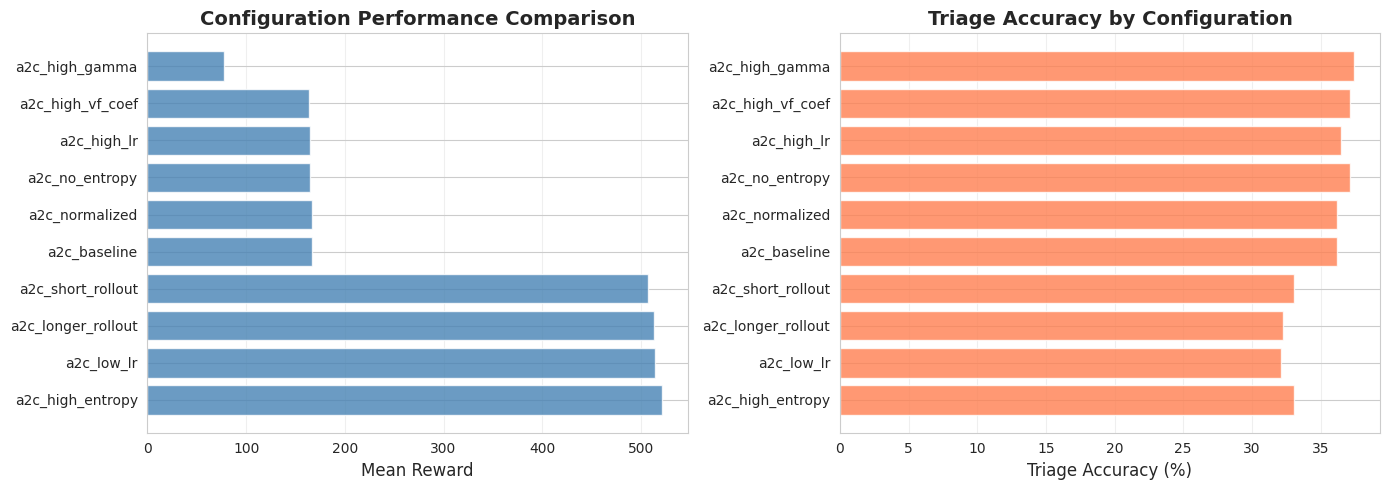


🏆 BEST CONFIGURATION: a2c_high_entropy
   Mean Reward: 521.17
   Triage Accuracy: 33.1%

   Hyperparameters:
     learning_rate: 0.0007
     gamma: 0.99
     n_steps: 5
     ent_coef: 0.05


In [ ]:
# Create results dataframe
sweep_df = pd.DataFrame(sweep_results)

# Save sweep results
sweep_csv_path = f"{PROJECT_DIR}/results/a2c_sweep_results.csv"
save_results_to_csv(sweep_results, sweep_csv_path)

# Display sorted results
print("\n" + "="*60)
print("SWEEP RESULTS (sorted by mean reward)")
print("="*60)
print(sweep_df.sort_values('mean_reward', ascending=False)[
    ['config_id', 'mean_reward', 'triage_accuracy', 'training_time_sec']
].to_string(index=False))
print("="*60)

# Plot comparison
plot_config_comparison(
    sweep_df,
    save_path=f"{PROJECT_DIR}/plots/a2c_sweep_comparison.png"
)

# Identify best config
best_config_id = sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'config_id']
best_config = next(c for c in configs if c['id'] == best_config_id)

print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
print(f"   Mean Reward: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'mean_reward']:.2f}")
print(f"   Triage Accuracy: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'triage_accuracy']:.1f}%")
print(f"\n   Hyperparameters:")
for key in ['learning_rate', 'gamma', 'n_steps', 'ent_coef']:
    print(f"     {key}: {best_config[key]}")


## 7. Full Training: Best Config with 5 Seeds (200K steps each)

**Purpose**: Train the best configuration with multiple seeds for statistical significance.

**Runtime**: ~3-4 hours on Colab GPU


In [22]:
# Full training with multiple seeds
print("\n" + "="*60)
print(f"FULL TRAINING: {best_config_id} with 5 seeds")
print("="*60)

full_results = []
full_models = {}
SEEDS = [42, 123, 456, 789, 1024]

for i, seed in enumerate(SEEDS):
    print(f"\n[Seed {i+1}/5] Training with seed={seed}")
    print("-" * 60)

    # Create environment
    env = ClinicEnv(seed=seed, max_steps=500)

    start_time = time.time()

    try:
        model, eval_results = train_a2c_config(
            best_config, env,
            total_timesteps=200000,
            seed=seed
        )

        elapsed = time.time() - start_time

        # Store results
        result = {
            "config_id": best_config_id,
            "seed": seed,
            "mean_reward": eval_results["mean_reward"],
            "std_reward": eval_results["std_reward"],
            "triage_accuracy": eval_results["mean_triage_accuracy"],
            "triage_accuracy_std": eval_results["std_triage_accuracy"],
            "mean_length": eval_results["mean_length"],
            "training_time_sec": elapsed
        }

        full_results.append(result)
        full_models[f"seed_{seed}"] = model

        print(f"✓ Completed in {elapsed:.1f}s")
        print(f"  Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
        print(f"  Triage Accuracy: {eval_results['mean_triage_accuracy']:.1f}% ± {eval_results['std_triage_accuracy']:.1f}%")

        # Save model to Drive
        model_path = f"{PROJECT_DIR}/models/a2c/{best_config_id}_seed{seed}.zip"
        model.save(model_path)
        print(f"  Model saved: {model_path}")

    except Exception as e:
        print(f"✗ Error training seed {seed}: {str(e)}")
        continue

    env.close()

print("\n" + "="*60)
print("FULL TRAINING COMPLETE!")
print("="*60)



FULL TRAINING: a2c_high_entropy with 5 seeds

[Seed 1/5] Training with seed=42
------------------------------------------------------------
✓ Completed in 488.2s
  Mean Reward: 506.95 ± 18.25
  Triage Accuracy: 32.6% ± 2.5%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_high_entropy_seed42.zip

[Seed 2/5] Training with seed=123
------------------------------------------------------------
✓ Completed in 484.5s
  Mean Reward: 512.85 ± 18.97
  Triage Accuracy: 33.5% ± 2.3%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_high_entropy_seed123.zip

[Seed 3/5] Training with seed=456
------------------------------------------------------------
✓ Completed in 482.6s
  Mean Reward: 146.62 ± 27.70
  Triage Accuracy: 36.6% ± 2.7%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_high_entropy_seed456.zip

[Seed 4/5] Training with seed=789
------------------------------------------------------------
✓ Completed in 485.2s
  Mean Reward: 534.68 ± 1

## 8. Final Results & Visualization


✓ Results saved to /content/drive/MyDrive/RL_Summative/results/a2c_full_results.csv

FINAL RESULTS (aggregated across 5 seeds)
Configuration: a2c_high_entropy
Total Timesteps: 200,000 per seed × 5 seeds = 1,000,000

Mean Reward: 441.87 ± 165.42
Triage Accuracy: 33.9% ± 1.6%
Avg Episode Length: 500.0
Total Training Time: 0.67 hours

✓ Plot saved to /content/drive/MyDrive/RL_Summative/plots/a2c_full_training.png


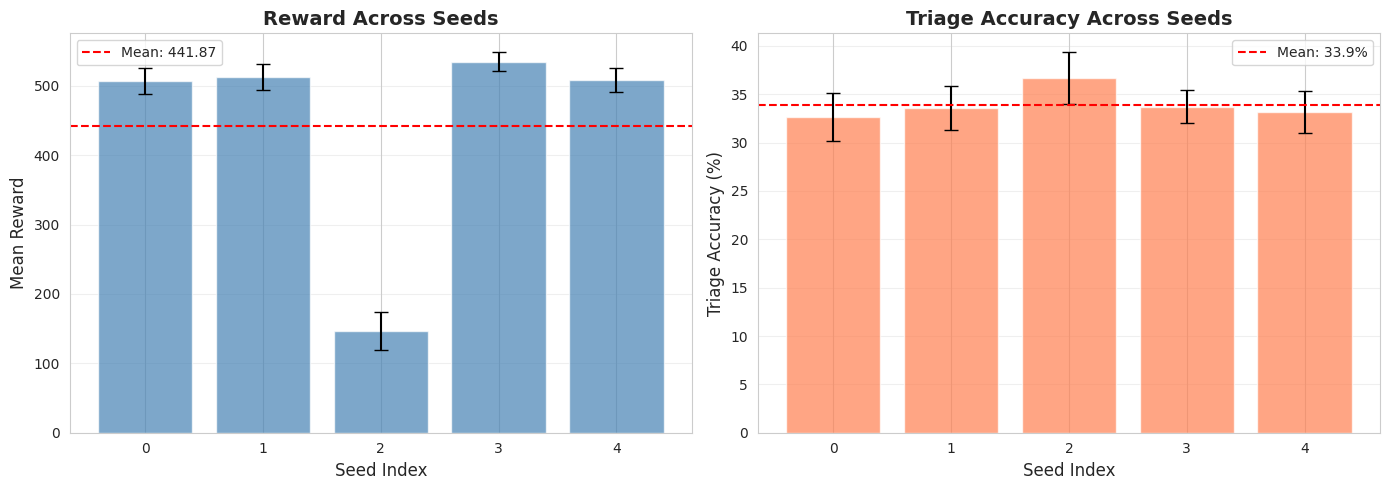

In [23]:
# Aggregate full training results
full_df = pd.DataFrame(full_results)

# Save full results
full_csv_path = f"{PROJECT_DIR}/results/a2c_full_results.csv"
save_results_to_csv(full_results, full_csv_path)

# Calculate statistics across seeds
print("\n" + "="*60)
print("FINAL RESULTS (aggregated across 5 seeds)")
print("="*60)
print(f"Configuration: {best_config_id}")
print(f"Total Timesteps: 200,000 per seed × 5 seeds = 1,000,000")
print()
print(f"Mean Reward: {full_df['mean_reward'].mean():.2f} ± {full_df['mean_reward'].std():.2f}")
print(f"Triage Accuracy: {full_df['triage_accuracy'].mean():.1f}% ± {full_df['triage_accuracy'].std():.1f}%")
print(f"Avg Episode Length: {full_df['mean_length'].mean():.1f}")
print(f"Total Training Time: {full_df['training_time_sec'].sum()/3600:.2f} hours")
print("="*60)

# Plot full training results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reward distribution
ax1 = axes[0]
ax1.bar(range(len(SEEDS)), full_df['mean_reward'],
        yerr=full_df['std_reward'], capsize=5, alpha=0.7, color='steelblue')
ax1.axhline(y=full_df['mean_reward'].mean(), color='red', linestyle='--',
            label=f"Mean: {full_df['mean_reward'].mean():.2f}")
ax1.set_xlabel('Seed Index', fontsize=12)
ax1.set_ylabel('Mean Reward', fontsize=12)
ax1.set_title('Reward Across Seeds', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Triage accuracy distribution
ax2 = axes[1]
ax2.bar(range(len(SEEDS)), full_df['triage_accuracy'],
        yerr=full_df['triage_accuracy_std'], capsize=5, alpha=0.7, color='coral')
ax2.axhline(y=full_df['triage_accuracy'].mean(), color='red', linestyle='--',
            label=f"Mean: {full_df['triage_accuracy'].mean():.1f}%")
ax2.set_xlabel('Seed Index', fontsize=12)
ax2.set_ylabel('Triage Accuracy (%)', fontsize=12)
ax2.set_title('Triage Accuracy Across Seeds', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
full_plot_path = f"{PROJECT_DIR}/plots/a2c_full_training.png"
plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Plot saved to {full_plot_path}")
plt.show()
